In [25]:
import os
import json
import paths
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights



In [26]:
parameters = {
    'lr': 0.001,
    'batch_size': 64,
    'epochs': 1,
    'num_workers': 6
}

In [27]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [28]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize(224),                       # Resize to fit ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet
])

In [29]:
# Load the datasets
train_dataset = datasets.ImageFolder(root=paths.TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(root=paths.TEST_DIR, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=parameters['batch_size'], shuffle=True, num_workers=parameters['num_workers'])
test_loader = DataLoader(test_dataset, batch_size=parameters['batch_size'], shuffle=False, num_workers=parameters['num_workers'])

In [30]:
class_names = sorted(os.listdir(paths.TRAIN_DIR))
class_names


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [31]:
num_classes = len(class_names)

# Load a pre-trained ResNet model
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features

# Modify the final fully connected layer to match the number of classes (10 for MNIST)
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

In [32]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=parameters['lr'])

In [33]:
# Training the model
loss_per_epoch = []
num_epochs = parameters['epochs']
progress_bar = tqdm(range(num_epochs), desc='Total Epochs')
for epoch in progress_bar:
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, leave=True, desc='Epoch progress'):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    progress_bar.set_postfix({'Loss': epoch_loss})
    loss_per_epoch.append(epoch_loss)


Total Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch progress:   0%|          | 0/94 [00:00<?, ?it/s]

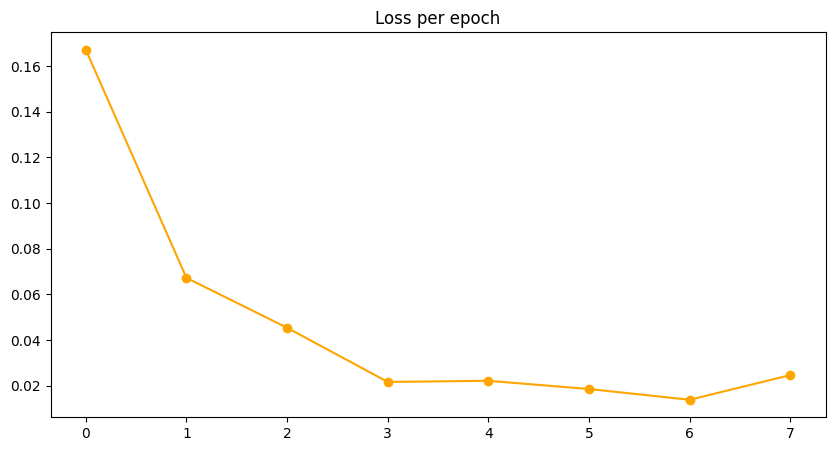

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Loss per epoch')
plt.plot(loss_per_epoch, marker='o', color='orange')
plt.show()

In [ ]:
torch.save(model, paths.MODEL_PATH)

with open(paths.MODEL_PARAMS_PATH, 'w') as f:
    json.dump(parameters, f)